<a href="https://colab.research.google.com/github/monicasjsu/Emerging-Software-Technologies-Project/blob/main/Pix2Pix_GAN_Validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Change directory to the project root directory
%cd /content/drive/MyDrive/Pix2Pix_GAN

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Pix2Pix_GAN


# Config

In [ ]:
from pprint import pprint

class Config(dict):
    def __getattr__(self, name):
        return self[name]

config = Config({
    'action': 'valid', # Change this to "test" to generate one image and "valid" to run tests on all validation dataset
    'validDatasetFolder': 'datasets/maps/val/',
    'npzValidDatasetPath': 'datasets/maps_valid.npz',
    'outputImageSize': (256, 512), # Training images are concatenated with validation images. So two squares images.

    'modelPath': 'checkpoints/models/model_108000.h5',
    'test_image': 'samples/sample_1.png',
    'valid_dataset_limit': 50
})

pprint(config)

{'action': 'valid',
 'modelPath': 'checkpoints/models/model_108000.h5',
 'npzValidDatasetPath': 'datasets/maps_valid.npz',
 'outputImageSize': (256, 512),
 'test_image': 'samples/sample_1.png',
 'validDatasetFolder': 'datasets/maps/val/'}


# Data loading and processing

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def plot_image(image_path):
  img = mpimg.imread(image_path)
  imgplot = plt.imshow(img)
  plt.show()

In [ ]:
# Normalize/Scale the pixel values to [-1,1] from [0, 255]
def scale_image(image_array):
    return (image_array - 127.5) / 127.5


In [ ]:
def rescale(input_image_array):
    return (input_image_array + 1) / 2.0

In [ ]:
from os import listdir

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from matplotlib import pyplot
from numpy import savez_compressed, load, ones
from numpy.random import randint

class Dataset:
    def __init__(self, input_folder, npz_path, output_image_size):
        self.input_folder = input_folder
        self.npz_path = npz_path
        self.output_image_size = output_image_size
        self.input = None
        self.target = None
        self.input_scaled = None
        self.target_scaled = None

    def convert_raw_to_array(self):
        input_images = []
        target_images = []

        for filename in listdir(self.input_folder):
            # Change the size of the image to the output size
            pil_image = load_img(self.input_folder + filename, target_size=self.output_image_size)
            image_array = img_to_array(pil_image)
            # As the source image and target image are concatenated side by side in the input image,
            # we need to divide it into input and target images by splitting in the middle.
            # Input Satellite images
            input_images.append(image_array[:, :256])
            # Target Map images
            target_images.append(image_array[:, 256:])

        return [input_images, target_images]

    # Method to read dataset in raw jpg format and convert it to compressed npz format.
    def convert_to_npz(self):
        [input_images_array, target_images_array] = self.convert_raw_to_array()
        savez_compressed(self.npz_path, input_images_array, target_images_array)
        print('Compressed dataset saved at ', self.npz_path)

    # Method to read npz dataset, extract and normalize training images
    def extract_train_target_images(self):
        data = load(self.npz_path)
        # Extract train and val images datasets
        self.input, self.target = data['arr_0'], data['arr_1']
        # Normalize the pixel values to [-1,1] from [0, 255]
        self.input_scaled = scale_image(self.input)
        self.target_scaled = scale_image(self.target)

    def process(self):
        # Convert raw images to compressed numpy (npz) format
        self.convert_to_npz()
        # Extract and normalize images from npz dataset
        self.extract_train_target_images()

    def plot_sample_input_target_images(self, num_samples):
        for i in range(num_samples):
            pyplot.subplot(2, num_samples, 1 + i)
            pyplot.axis('off')
            pyplot.imshow(self.input[i].astype('uint8'))
        # plot target image
        for i in range(num_samples):
            pyplot.subplot(2, num_samples, 1 + num_samples + i)
            pyplot.axis('off')
            pyplot.imshow(self.target[i].astype('uint8'))
        pyplot.show()

    # Returns a batch of random samples
    def get_random_sample_input_batch(self, num_samples, patch_shape):
        # choose random instances
        index = randint(0, self.input_scaled.shape[0], num_samples)
        input_sat, target_map = self.input_scaled[index], self.target_scaled[index]
        # Fill real y with all ones
        y = ones((num_samples, patch_shape, patch_shape, 1))
        return [input_sat, target_map], y


# Evaluation

In [ ]:
from keras_preprocessing.image import load_img, img_to_array
from matplotlib import pyplot
from numpy import vstack, expand_dims
from tensorflow.python.keras.models import load_model

class Evaluator:
    def __init__(self, model_path):
        self.model_path = model_path
        self.model = load_model(self.model_path)

    def predict(self, input_img):
        scaled_input_image = self.load_image(input_img)
        target_image = self.model.predict(scaled_input_image)
        self.plot_input_gen_images(scaled_input_image, target_image)

    @staticmethod
    def load_image(filename, size=(256, 256)):
        image = load_img(filename, target_size=size)
        image_array = img_to_array(image)
        # Normalize/Scale the pixel values to [-1,1] from [0, 255]
        scaled_image = scale_image(image_array)
        return expand_dims(scaled_image, 0)

    # plot source, generated and target images
    @staticmethod
    def plot_input_gen_images(input_img, gen_img):
        images = vstack((input_img, gen_img))
        # scale back to [0,1] from [-1, 1]
        images = rescale(images)
        titles = ['Input', 'Generated']
        for i in range(len(images)):
            # define subplot
            pyplot.subplot(1, 2, 1 + i)
            # turn off axis
            pyplot.axis('off')
            # plot raw pixel data
            pyplot.imshow(images[i])
            # show title
            pyplot.title(titles[i])
        pyplot.show()

    # plot source, generated and target images
    @staticmethod
    def plot_input_gen_target_images(input_img, gen_img, target):
        images = vstack((input_img, gen_img, target))
        # scale back to [0,1] from [-1, 1]
        images = rescale(images)
        titles = ['Input', 'Generated', 'Target']
        for i in range(len(images)):
            # define subplot
            pyplot.subplot(1, 3, 1 + i)
            # turn off axis
            pyplot.axis('off')
            # plot raw pixel data
            pyplot.imshow(images[i])
            # show title
            pyplot.title(titles[i])
        pyplot.show()

    def test_all_val_images(self, valid_dataset):
        limit = min(config.valid_dataset_limit, len(valid_dataset.input_scaled))
        for i in range(len(valid_dataset.input_scaled)):
            input_image = expand_dims(valid_dataset.input_scaled[i], 0)
            target_image = expand_dims(valid_dataset.target_scaled[i], 0)
            generated_image = self.model.predict(input_image)
            self.plot_input_gen_target_images(input_image, generated_image, target_image)

Npz compressed dataset already saved at  datasets/maps_valid.npz


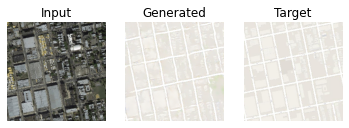

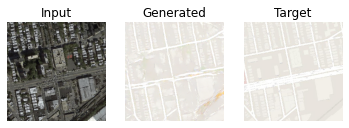

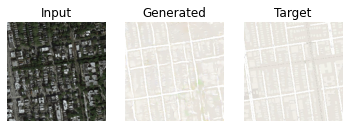

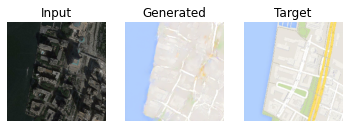

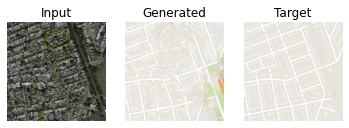

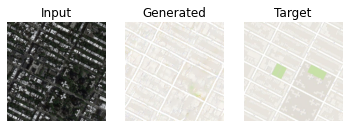

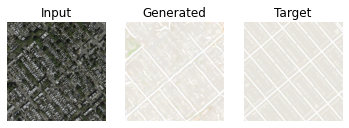

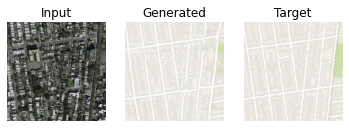

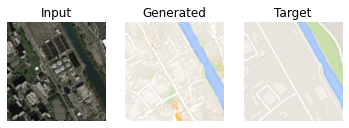

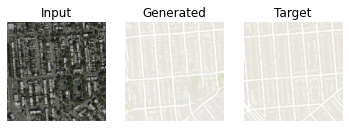

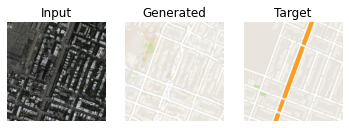

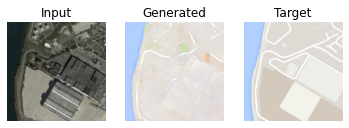

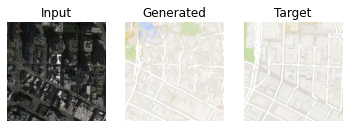

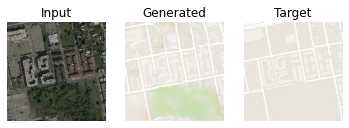

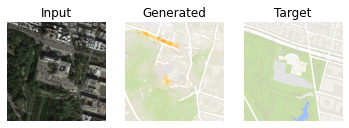

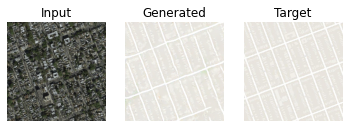

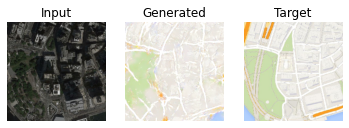

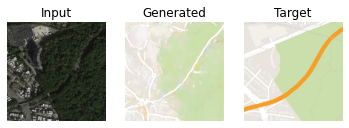

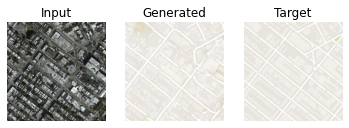

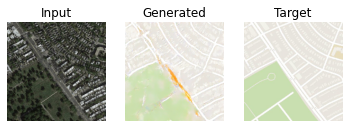

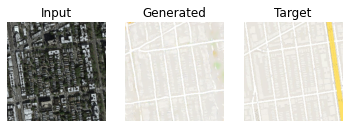

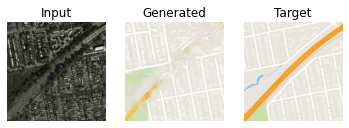

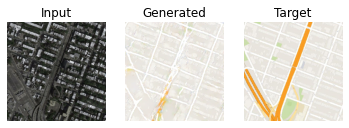

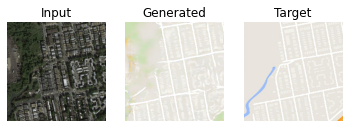

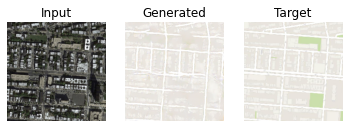

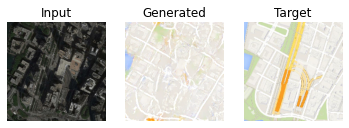

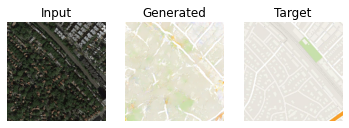

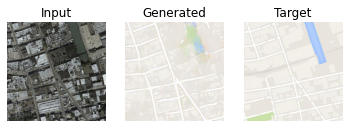

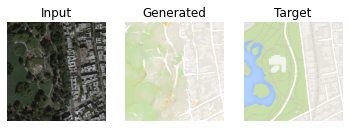

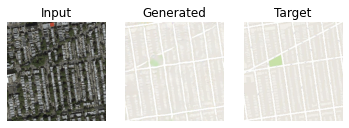

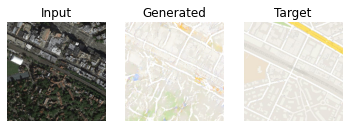

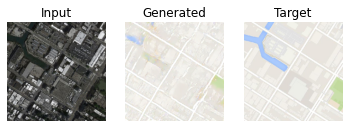

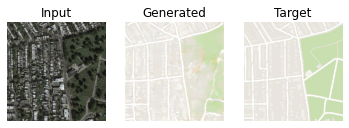

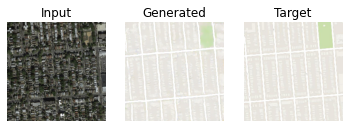

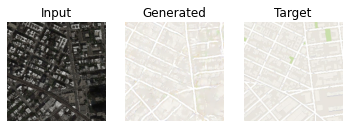

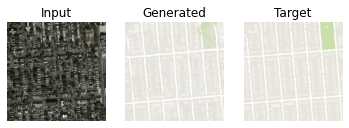

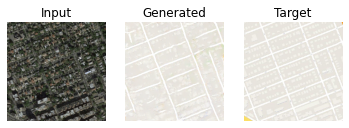

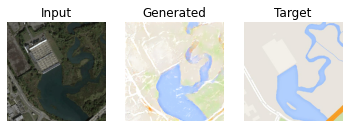

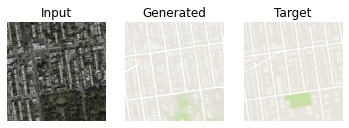

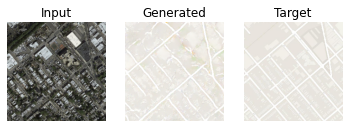

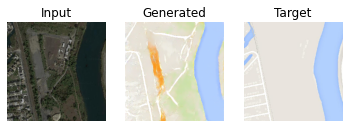

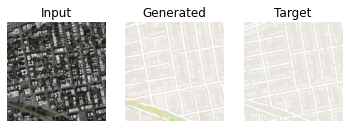

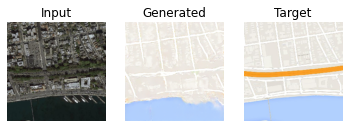

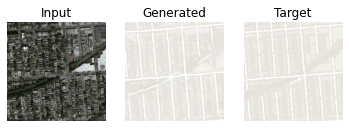

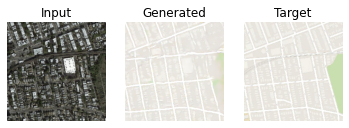

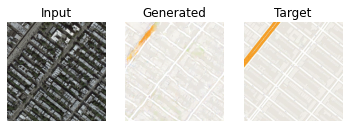

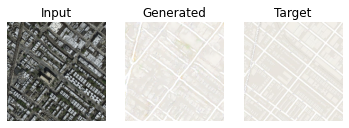

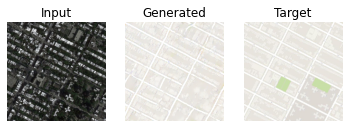

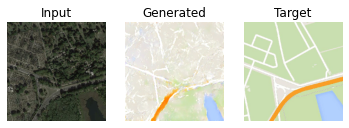

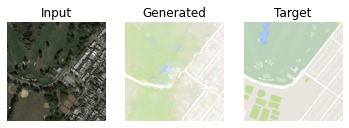

In [ ]:
import os

if config.action == "test":
    evaluator = Evaluator(config.modelPath)
    evaluator.predict(config.test_image)
else:
    valid_dataset = Dataset(config.validDatasetFolder, config.npzValidDatasetPath, config.outputImageSize)
    if os.path.exists(config.npzValidDatasetPath):
        valid_dataset.extract_train_target_images()
        print('Npz compressed dataset already saved at ', config.npzValidDatasetPath)
    else:
        # Convert the raw image dataset into npz compressed format and extract
        valid_dataset.process()
    evaluator = Evaluator(config.modelPath)
    evaluator.test_all_val_images(valid_dataset)